In [1]:
import logging
import warnings
import re
import argparse
import yaml

import pandas as pd

from src.ingest import *
from src.aggregate import *
from src.preprocess import *
from src.hypertune import *
from src.train import *
import os
import yaml

# A. Baseline Scenario: No Promotion Plan

In [ ]:
data_dict = Ingestion(org_path=r"D:\Study\UNIVERSITY\THIRD YEAR\Business Analytics\ASSIGNMENT 1_ Sales Data Analysis\test_2025_data\no_promo").load_data()
agg = Aggregation(data_dict, required_shiftback=12)
merged = agg.merge_data()

org_df = merged[agg.org_cols]
lag_ws = [12, 15]
org_df = generate_lagged_feats(org_df, ["New_Sales"], lag_ws)
org_df["Month"] = org_df.index.month.astype(str)
org_df["Year"] = org_df.index.year
org_df["Quarter"] = org_df.index.quarter.astype(str)

nn_X_tr, nn_y_tr, nn_X_te, nn_y_te = agg.split_train_test(org_df, target_feat="New_Sales")

# Preprocess
nn_preprocessor = CustomPreprocessor()
nn_preprocessor.fit(nn_X_tr, nn_y_tr, mi_pct = 0.0)
nn_X_tr = nn_preprocessor.transform(nn_X_tr)
nn_X_te = nn_preprocessor.transform(nn_X_te)

# Hyperparameter tuning
model_name = "lstm_2025"
tuner = HyperTuner(model_name, n_features=60, ts_splits=5)
feats = tuner.run_permutation_importance(nn_X_tr, nn_y_tr)
mandatory = [
    c for c in nn_X_tr.columns
    if re.match(r"(?i)(month|quarter|year)", c)
]
feats = list(dict.fromkeys(feats + mandatory))
tuner.tune(n_trials=100)

with open("./src/hypertune_results.yaml", "r") as f:
    results = yaml.safe_load(f)

if model_name in results.get("results", {}) and "params" in results["results"][model_name]:
    model_params = results["results"][model_name]["params"]
    print(f"NUMBER OF FINAL FEATURES FOR {model_name.upper()}: {len(feats)}")

    trainer = ModelTrainer(model_name, params=model_params)
    trainer.fit(nn_X_tr[feats], nn_y_tr)
    trainer.model.summary()
    preds = trainer.predict(nn_X_te[feats])
    trainer.generate_shap_plot(X_train=nn_X_tr[feats], save=True)

Original frequency: MS
Converted format: period[M]
Original frequency: None
Converted format: period[M]
Original frequency: YS-JAN

=== Initial DataFrame ===
Columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']
Dtypes:
Promo_Type           object
Budget_USD          float64
New_Sales_lag_12    float64
New_Sales_lag_15    float64
Month                object
Year                  int32
Quarter              object
dtype: object

=== After dropna ===
Remaining columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']

=== Cycle features ===
[]

=== Numerical features ===
Count: 4
First 10: ['Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Year']

=== Categorical features ===
Count: 3
['Promo_Type', 'Month', 'Quarter']
╒══════════════════╤═════════════╕
│                  │          MI │
╞══════════════════╪═════════════╡
│ Budget_USD       │ 2.22045e-16 │
├──────────────────┼─────────

[I 2025-05-24 21:13:15,539] A new study created in memory with name: no-name-7174b458-1e41-4df9-aaa2-0dae16f67b34


Selected features for lstm_2025: ['Quarter_3', 'New_Sales_lag_12', 'Quarter_4', 'Promo_Type_Discount', 'Month_6', 'Month_8', 'Month_3', 'Month_4', 'Month_2', 'Month_7', 'Promo_Type_Cashback', 'Year', 'Budget_USD', 'Month_11', 'Month_12', 'Month_5', 'Month_10', 'Quarter_2', 'Month_9', 'New_Sales_lag_15']


[I 2025-05-24 21:13:17,303] Trial 0 finished with value: 0.01612160288987889 and parameters: {'lr': 0.009551776667117763, 'units': 128, 'batch_size': 32, 'patience': 12}. Best is trial 0 with value: 0.01612160288987889.
[I 2025-05-24 21:13:18,751] Trial 1 finished with value: 0.017391668572357213 and parameters: {'lr': 0.007490159819834997, 'units': 96, 'batch_size': 16, 'patience': 8}. Best is trial 0 with value: 0.01612160288987889.
[I 2025-05-24 21:13:20,176] Trial 2 finished with value: 0.01751958280963237 and parameters: {'lr': 0.009869304916918186, 'units': 112, 'batch_size': 16, 'patience': 10}. Best is trial 0 with value: 0.01612160288987889.
[I 2025-05-24 21:13:21,797] Trial 3 finished with value: 0.013827060654695187 and parameters: {'lr': 0.0076220608848105685, 'units': 112, 'batch_size': 16, 'patience': 10}. Best is trial 3 with value: 0.013827060654695187.
[I 2025-05-24 21:13:23,406] Trial 4 finished with value: 0.01938092493854783 and parameters: {'lr': 0.0081544020229863

Best params for lstm_2025: {'lr': 0.008176349697609511, 'units': 128, 'batch_size': 32, 'patience': 8}
NUMBER OF FINAL FEATURES FOR LSTM_2025: 20
Epoch 1/50
11/11 [==============================] - 1s 18ms/step - loss: 0.0214 - val_loss: 0.0920
Epoch 2/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0089 - val_loss: 0.0256
Epoch 3/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0336
Epoch 4/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0135
Epoch 5/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0126
Epoch 6/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0136
Epoch 7/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0122
Epoch 8/50
11/11 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0132
Epoch 9/50
11/11 [==============================] - 0s 3ms/step - los

  0%|          | 0/360 [00:00<?, ?it/s]

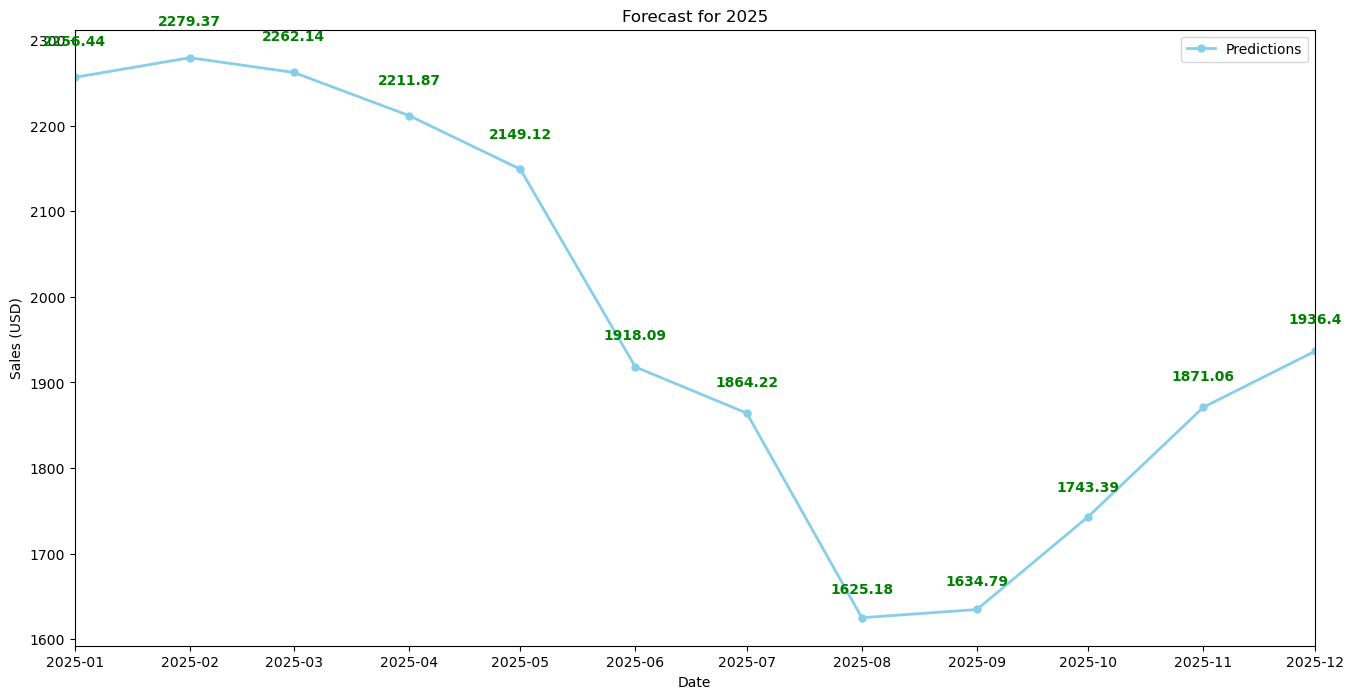

In [3]:
# plot preds for 2025
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(nn_X_te.index, preds, marker="o", markersize=5, color = "skyblue", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025")
ax.set_xlim(nn_X_te.index.min(), nn_X_te.index.max())
ax.legend(["Predictions"])
for i in range(len(nn_X_te.index)):
    ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')

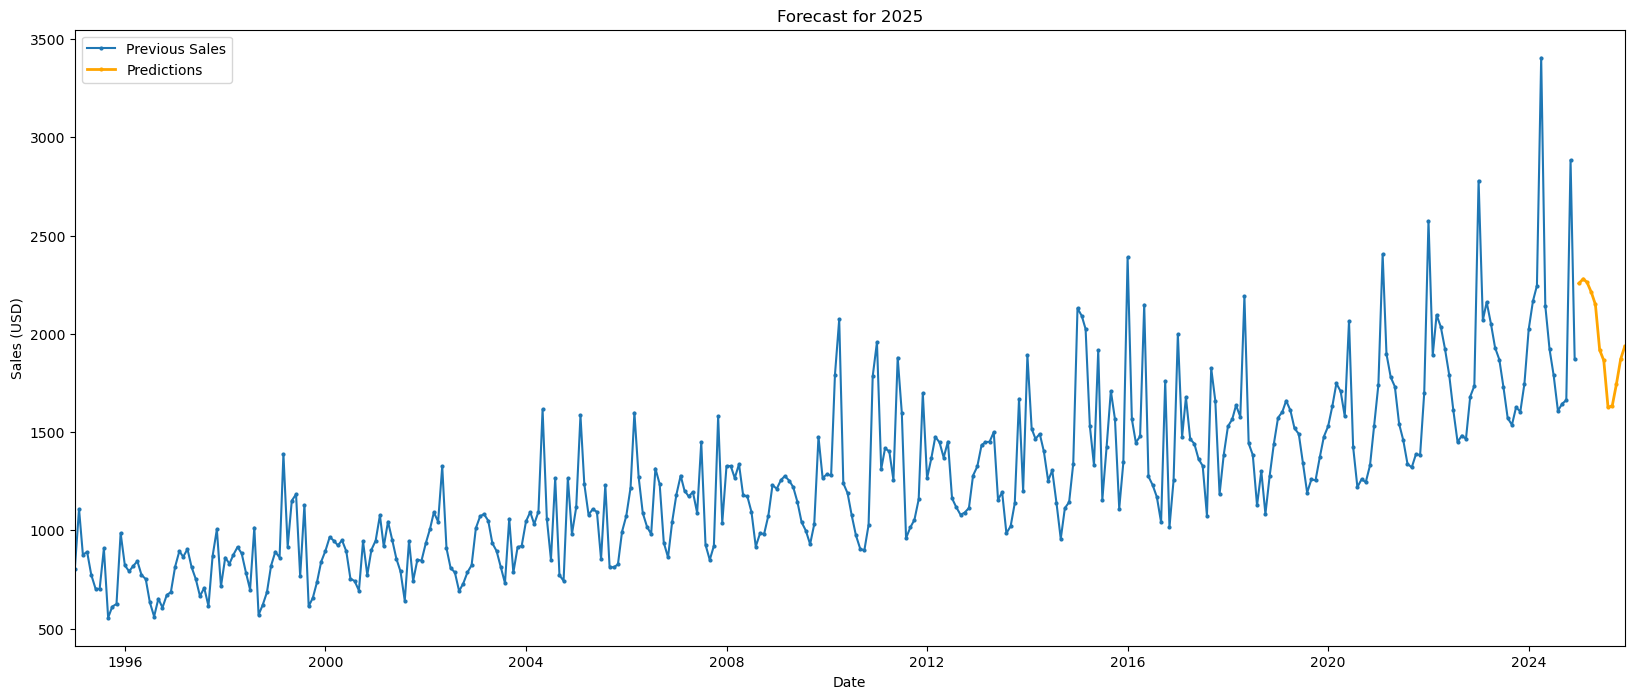

In [4]:
# plot 2025 along with prev years sales
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(nn_X_tr.index, nn_y_tr, marker="o", markersize=2)
ax.plot(nn_X_te.index, preds, marker="o", markersize=2, color = "orange", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025")
ax.set_xlim(nn_X_tr.index.min(), nn_X_te.index.max())
ax.legend(["Previous Sales", "Predictions"])
# for i in range(len(nn_X_te.index)):
#     ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')

# B. 1st Scenario: Forecasting With Promotion Plan 2025

In [2]:
data_dict = Ingestion(org_path=r"D:\Study\UNIVERSITY\THIRD YEAR\Business Analytics\ASSIGNMENT 1_ Sales Data Analysis\test_2025_data\with_promo_scen1").load_data()
agg = Aggregation(data_dict, required_shiftback=12)
merged = agg.merge_data()

org_df = merged[agg.org_cols]
lag_ws = [12, 15]
org_df = generate_lagged_feats(org_df, ["New_Sales"], lag_ws)
org_df["Month"] = org_df.index.month.astype(str)
org_df["Year"] = org_df.index.year
org_df["Quarter"] = org_df.index.quarter.astype(str)

nn_X_tr, nn_y_tr, nn_X_te, nn_y_te = agg.split_train_test(org_df, target_feat="New_Sales")

# Preprocess
nn_preprocessor = CustomPreprocessor()
nn_preprocessor.fit(nn_X_tr, nn_y_tr, mi_pct = 0.0)
nn_X_tr = nn_preprocessor.transform(nn_X_tr)
nn_X_te = nn_preprocessor.transform(nn_X_te)

# Load hypertuned results (features shortlisted & hyperparameters)
with open("./src/hypertune_results.yaml", "r") as f:
    results = yaml.safe_load(f)

model_name = "lstm_2025"
if model_name in results.get("results", {}) and "params" in results["results"][model_name]:
    model_params = results["results"][model_name]["params"]
    feats = results["results"][model_name]["features"]
    print(f"NUMBER OF FINAL FEATURES FOR {model_name.upper()}: {len(feats)}")

    trainer = ModelTrainer(model_name, params=model_params)
    trainer._load()
    trainer.model.summary()
    preds = trainer.predict(nn_X_te[feats])
    # trainer.generate_shap_plot(X_train=nn_X_tr[feats], save=True)

Original frequency: MS
Converted format: period[M]
Original frequency: None
Converted format: period[M]
Original frequency: YS-JAN

=== Initial DataFrame ===
Columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']
Dtypes:
Promo_Type           object
Budget_USD          float64
New_Sales_lag_12    float64
New_Sales_lag_15    float64
Month                object
Year                  int32
Quarter              object
dtype: object

=== After dropna ===
Remaining columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']

=== Cycle features ===
[]

=== Numerical features ===
Count: 4
First 10: ['Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Year']

=== Categorical features ===
Count: 3
['Promo_Type', 'Month', 'Quarter']
╒══════════════════╤═════════════╕
│                  │          MI │
╞══════════════════╪═════════════╡
│ Budget_USD       │ 2.22045e-16 │
├──────────────────┼─────────

In [5]:
org_df.tail(12)

,New_Sales,Promo_Type,Budget_USD,New_Sales_lag_12,New_Sales_lag_15,Month,Year,Quarter
Date,,,,,,,,
2025-01-01,NaN,Discount,17000.0,2022.519058,1626.091457,1,2025,1
2025-02-01,NaN,NaN,NaN,2166.333237,1603.957307,2,2025,1
2025-03-01,NaN,NaN,NaN,2244.864957,1746.697420,3,2025,1
2025-04-01,NaN,NaN,NaN,3404.428595,2022.519058,4,2025,2
2025-05-01,NaN,NaN,NaN,2142.697477,2166.333237,5,2025,2
2025-06-01,NaN,NaN,NaN,1921.243494,2244.864957,6,2025,2
2025-07-01,NaN,NaN,NaN,1788.132301,3404.428595,7,2025,3
2025-08-01,NaN,NaN,NaN,1607.835902,2142.697477,8,2025,3
2025-09-01,NaN,NaN,NaN,1644.318122,1921.243494,9,2025,3


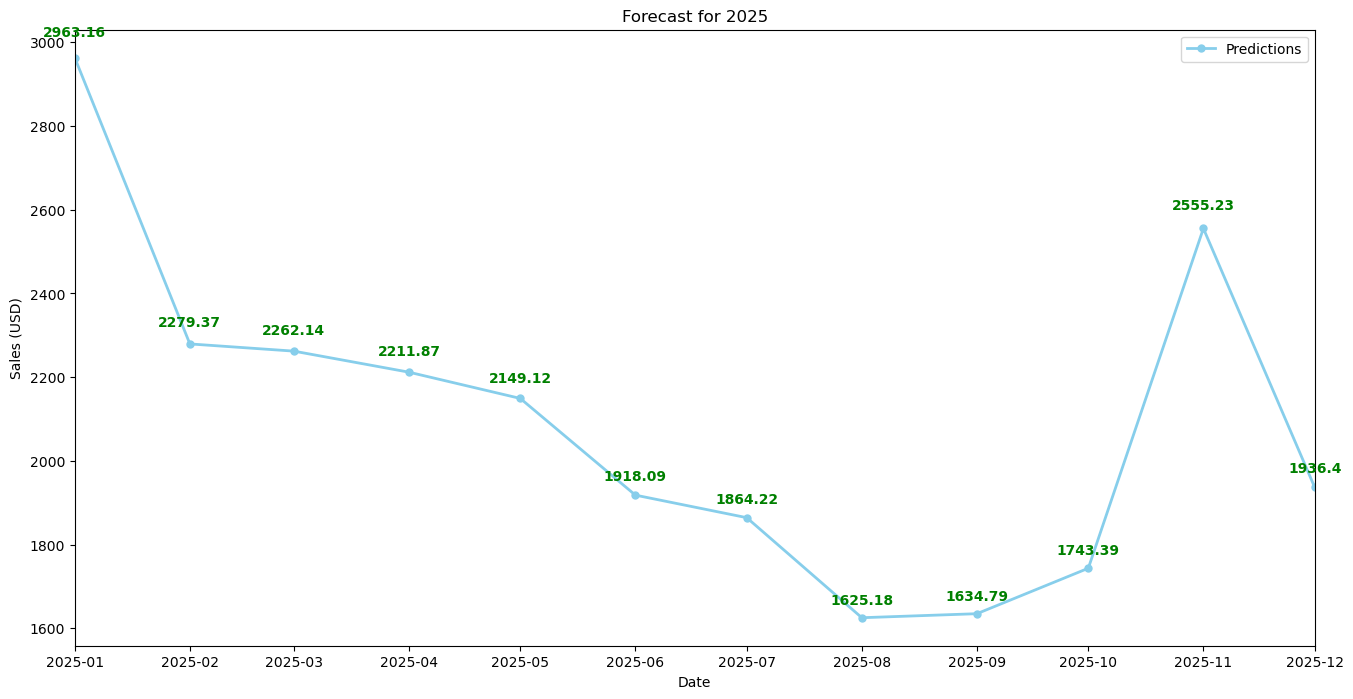

In [3]:
sales_prediction = pd.DataFrame(preds, index=nn_X_te.index, columns=["Sales"])
OUTPUT_DIR = "./models/lstm_2025_evaluation/"

sales_prediction.to_csv(os.path.join(OUTPUT_DIR, "sales_prediction_promo_scen1.csv"))

# plot preds for 2025
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(nn_X_te.index, preds, marker="o", markersize=5, color = "skyblue", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025")
ax.set_xlim(nn_X_te.index.min(), nn_X_te.index.max())
ax.legend(["Predictions"])
for i in range(len(nn_X_te.index)):
    ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')

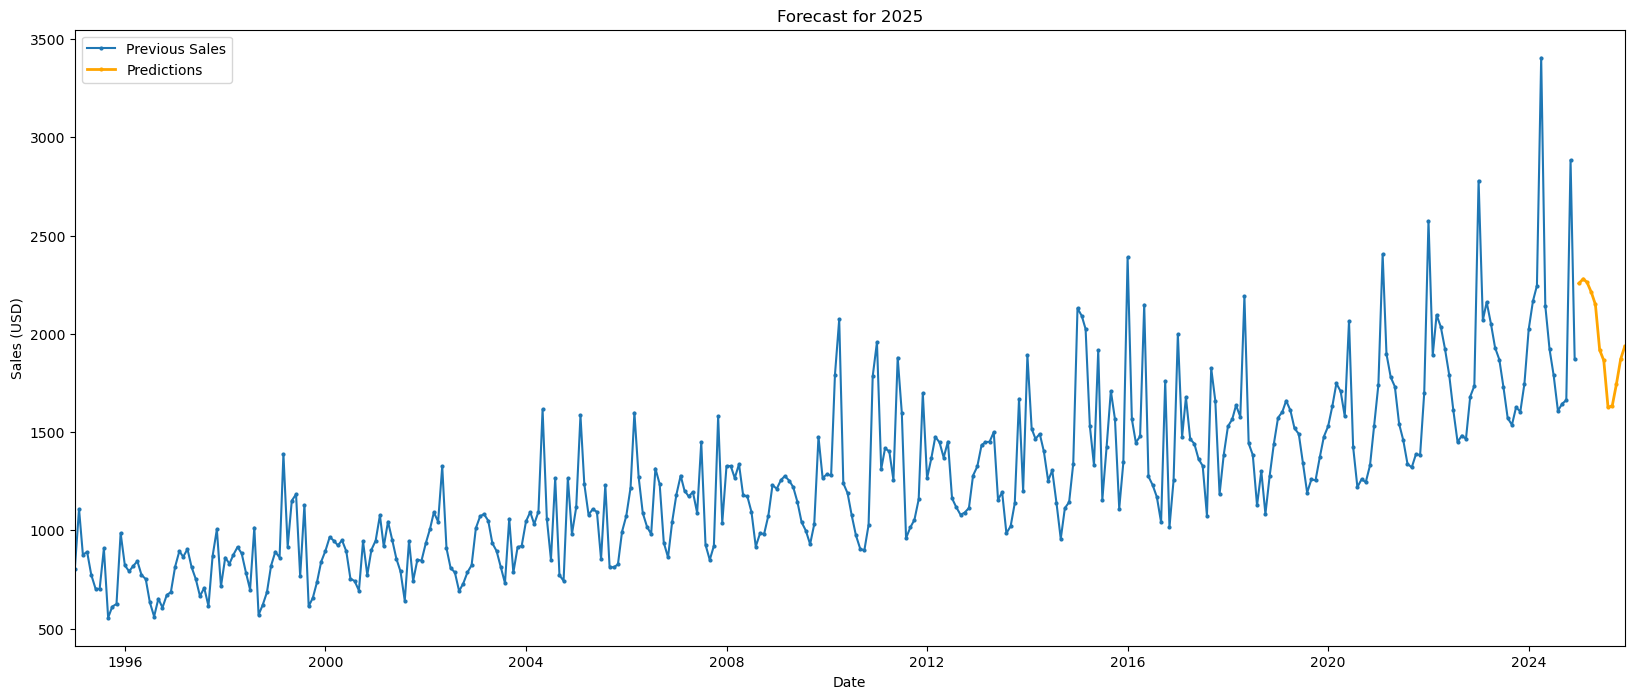

In [ ]:
# plot 2025 along with prev years sales
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(nn_X_tr.index, nn_y_tr, marker="o", markersize=2)
ax.plot(nn_X_te.index, preds, marker="o", markersize=2, color = "orange", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025")
ax.set_xlim(nn_X_tr.index.min(), nn_X_te.index.max())
ax.legend(["Previous Sales", "Predictions"])
# for i in range(len(nn_X_te.index)):
#     ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')

# C. 2nd Scenario: Forecasting With Promotion Plan 2025

In [ ]:
data_dict = Ingestion(org_path=r"D:\Study\UNIVERSITY\THIRD YEAR\Business Analytics\ASSIGNMENT 1_ Sales Data Analysis\test_2025_data\with_promo_scen2").load_data()
agg = Aggregation(data_dict, required_shiftback=12)
merged = agg.merge_data()

org_df = merged[agg.org_cols]
lag_ws = [12, 15]
org_df = generate_lagged_feats(org_df, ["New_Sales"], lag_ws)
org_df["Month"] = org_df.index.month.astype(str)
org_df["Year"] = org_df.index.year
org_df["Quarter"] = org_df.index.quarter.astype(str)

nn_X_tr, nn_y_tr, nn_X_te, nn_y_te = agg.split_train_test(org_df, target_feat="New_Sales")

# Preprocess
nn_preprocessor = CustomPreprocessor()
nn_preprocessor.fit(nn_X_tr, nn_y_tr, mi_pct = 0.0)
nn_X_tr = nn_preprocessor.transform(nn_X_tr)
nn_X_te = nn_preprocessor.transform(nn_X_te)

# Load hypertuned results (features shortlisted & hyperparameters)
with open("./src/hypertune_results.yaml", "r") as f:
    results = yaml.safe_load(f)

model_name = "lstm_2025"
if model_name in results.get("results", {}) and "params" in results["results"][model_name]:
    model_params = results["results"][model_name]["params"]
    feats = results["results"][model_name]["features"]
    print(f"NUMBER OF FINAL FEATURES FOR {model_name.upper()}: {len(feats)}")

    trainer = ModelTrainer(model_name, params=model_params)
    trainer._load()
    trainer.model.summary()
    preds = trainer.predict(nn_X_te[feats])
    # trainer.generate_shap_plot(X_train=nn_X_tr[feats], save=True)

Original frequency: MS
Converted format: period[M]
Original frequency: None
Converted format: period[M]
Original frequency: YS-JAN

=== Initial DataFrame ===
Columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']
Dtypes:
Promo_Type           object
Budget_USD          float64
New_Sales_lag_12    float64
New_Sales_lag_15    float64
Month                object
Year                  int32
Quarter              object
dtype: object

=== After dropna ===
Remaining columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']

=== Cycle features ===
[]

=== Numerical features ===
Count: 4
First 10: ['Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Year']

=== Categorical features ===
Count: 3
['Promo_Type', 'Month', 'Quarter']
╒══════════════════╤═════════════╕
│                  │          MI │
╞══════════════════╪═════════════╡
│ Budget_USD       │ 2.22045e-16 │
├──────────────────┼─────────

  0%|          | 0/360 [00:00<?, ?it/s]

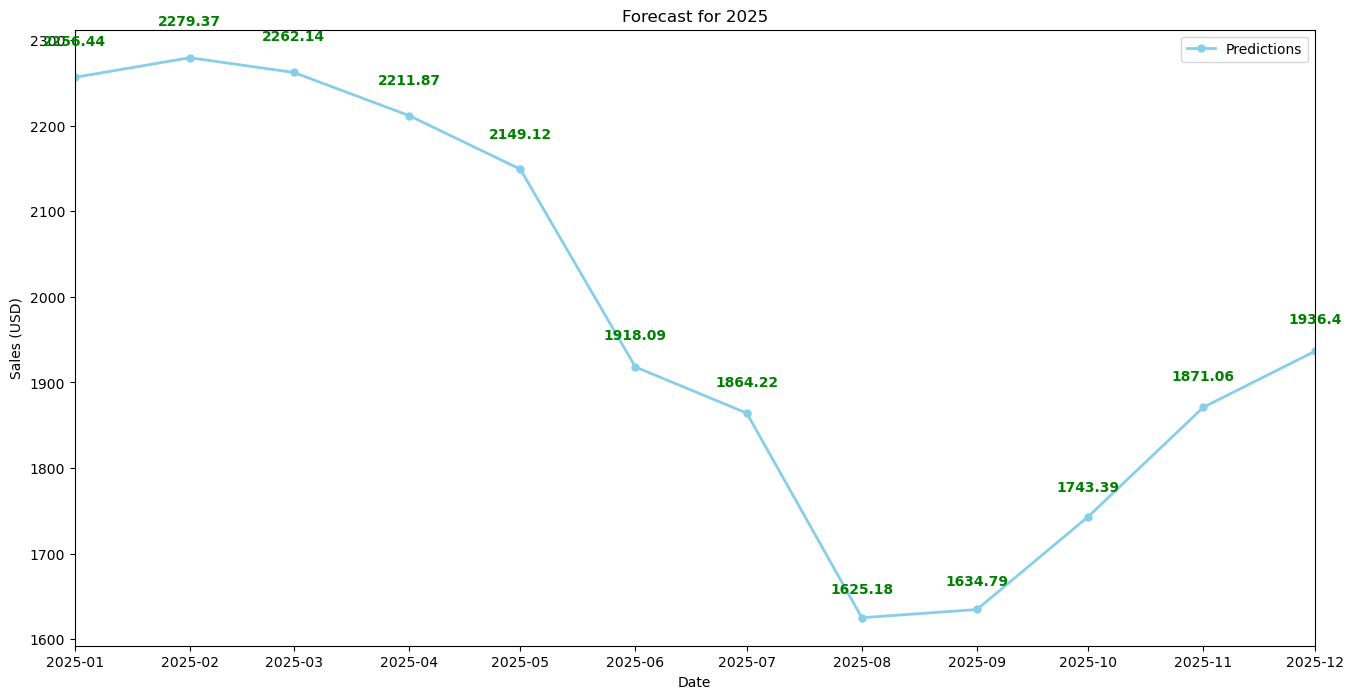

In [ ]:
sales_prediction = pd.DataFrame(preds, index=nn_X_te.index, columns=["Sales"])
OUTPUT_DIR = "./models/lstm_2025_evaluation/"

sales_prediction.to_csv(os.path.join(OUTPUT_DIR, "sales_prediction_promo_scen1.csv"))

# plot preds for 2025
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(nn_X_te.index, preds, marker="o", markersize=5, color = "skyblue", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025")
ax.set_xlim(nn_X_te.index.min(), nn_X_te.index.max())
ax.legend(["Predictions"])
for i in range(len(nn_X_te.index)):
    ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')

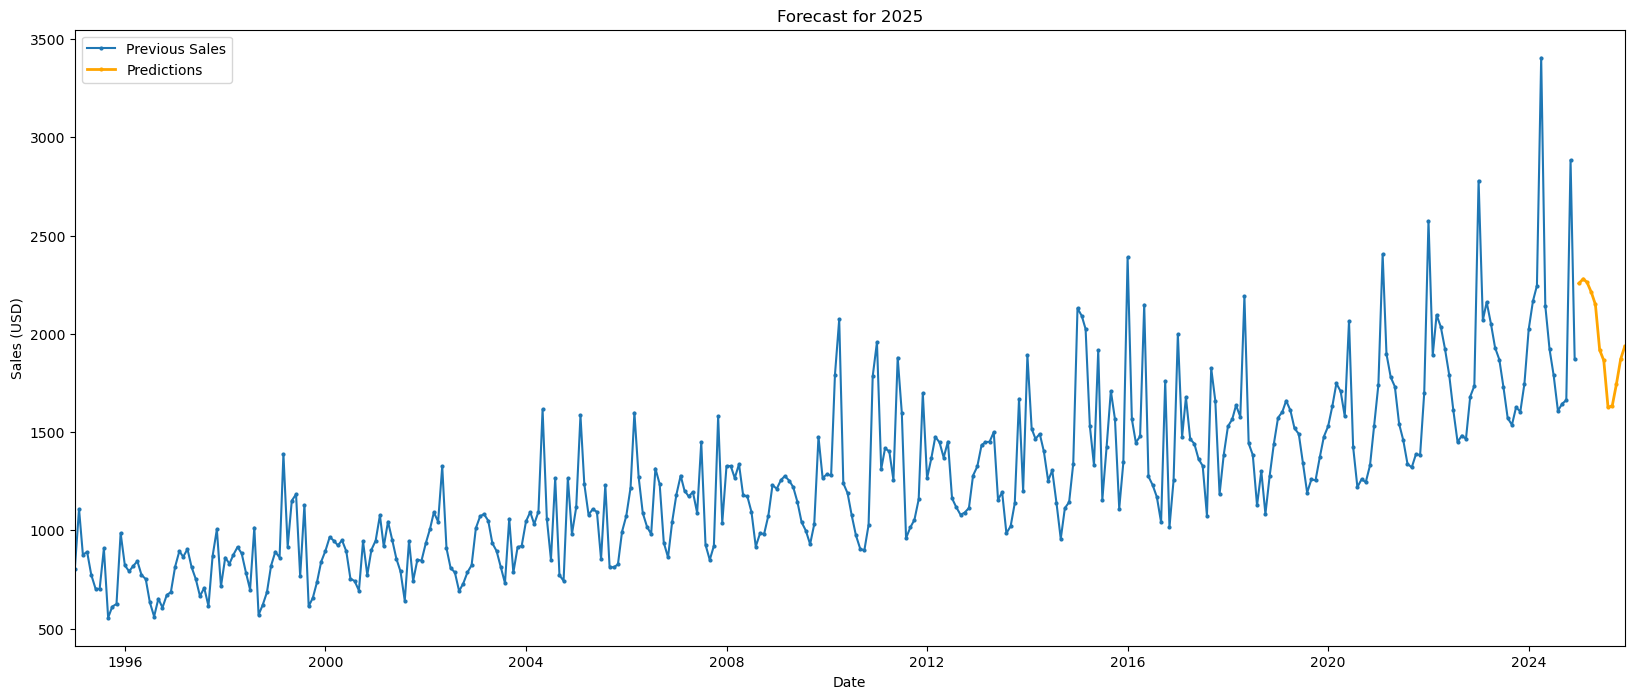

In [ ]:
# plot 2025 along with prev years sales
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(nn_X_tr.index, nn_y_tr, marker="o", markersize=2)
ax.plot(nn_X_te.index, preds, marker="o", markersize=2, color = "orange", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025")
ax.set_xlim(nn_X_tr.index.min(), nn_X_te.index.max())
ax.legend(["Previous Sales", "Predictions"])
# for i in range(len(nn_X_te.index)):
#     ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')